# Exercise 2.1: Binary Classification with JAX and Keras

In diesem Notebook sollten Sie die logistische Regression aus dem ersten Notebook nachbilden, diesmal jedoch das Autodiff-Framework von JAX und Keras verwenden.

In [23]:
import platform
import subprocess
import os
from datetime import datetime

# --- JAX ---
import jax
import jax.numpy as jnp

# --- NumPy ---
import numpy as np

# --- PyTorch ---
import torch

# --- Keras 3 ---
os.environ["KERAS_BACKEND"] = "torch"   # or "jax", depending on usage
import keras

print("=== Python & OS Info ===")
print("Date: {}".format(datetime.now()))
print(f"Python version:      {platform.python_version()}")
print(f"System:              {platform.system()}")
print(f"Machine:             {platform.machine()}")             # arm64 on Apple Silicon
print(f"Processor:           {platform.processor()}")
print(f"Mac version:         {platform.mac_ver()[0]}")           # macOS version
print()
# Optionally: Detect Apple chip
def get_chip_info():
    try:
        out = subprocess.check_output(
            ["sysctl", "-n", "machdep.cpu.brand_string"]
        ).decode().strip()
        return out
    except Exception:
        return "unknown"

print(f"Chip:          {get_chip_info()}")
print()

print("=== JAX Info ===")
print(f"JAX version:         {jax.__version__}")
print(f"JAX devices:         {jax.devices()}")
print()

print("=== PyTorch Info ===")
print(f"PyTorch version:     {torch.__version__}")
print(f"CUDA available:      {torch.cuda.is_available()}")
print(f"Device:              {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
print()

print("=== NumPy & Keras ===")
print(f"NumPy version:       {np.__version__}")
print(f"Keras version:       {keras.__version__}")
print(f"Keras backend:       {keras.config.backend()}")

=== Python & OS Info ===
Date: 2026-01-06 16:21:00.773401
Python version:      3.12.3
System:              Linux
Machine:             x86_64
Processor:           x86_64
Mac version:         

Chip:          unknown

=== JAX Info ===
JAX version:         0.8.2
JAX devices:         [CpuDevice(id=0)]

=== PyTorch Info ===
PyTorch version:     2.9.1+cu128
CUDA available:      False
Device:              cpu

=== NumPy & Keras ===
NumPy version:       2.4.0
Keras version:       3.13.0
Keras backend:       torch


sysctl: cannot stat /proc/sys/machdep/cpu/brand_string: No such file or directory


### Generate training data

In [24]:
import numpy as np

def generate_training_data(ntrain=200, scale=6.0, seed=None):
    """
    Reproduce the training data (x2, y0) from 01_mlp.ipynb.

    - 2D inputs start uniform on [0, scale]^2
    - Then mapped into four quadrants
    - Labels: quadrants I & III -> 1, quadrants II & IV -> 0
    - Final features x2 are sigmoid-transformed coordinates (perzeptron with w = I, b = 0)
    """
    rng = np.random.default_rng(seed)

    # 2d-Inputs (this is x0 in the notebook)
    x0 = rng.random((ntrain, 2))
    x0 *= scale

    # Quadrant manipulation exactly as in the notebook
    q = ntrain // 4

    # indices [q : 2q): flip x -> quadrant II
    x0[q:2*q, 0] *= -1.0

    # indices [2q : 3q): flip y -> quadrant IV
    x0[2*q:3*q, 1] *= -1.0

    # indices [3q : ntrain): flip both -> quadrant III
    x0[3*q:, :] *= -1.0

    # labels (y0 in the notebook)
    y0 = np.ones(ntrain, dtype=float)
    y0[q:2*q] = 0.0        # quadrant II
    y0[2*q:3*q] = 0.0      # quadrant IV
    # first q and last q remain 1.0 (quadrants I & III)

    # Perzeptron transform with w = I, b = 0 -> this is x2 in the notebook
    def sigmoid(z):
        return 1.0 / (1.0 + np.exp(-z))

    x2 = sigmoid(x0)

    return x2, y0

# In the first notebook a scale of 6.0 was used, here we use 1.0
x2, y0 = generate_training_data(ntrain=200, scale=1.0, seed=42) 

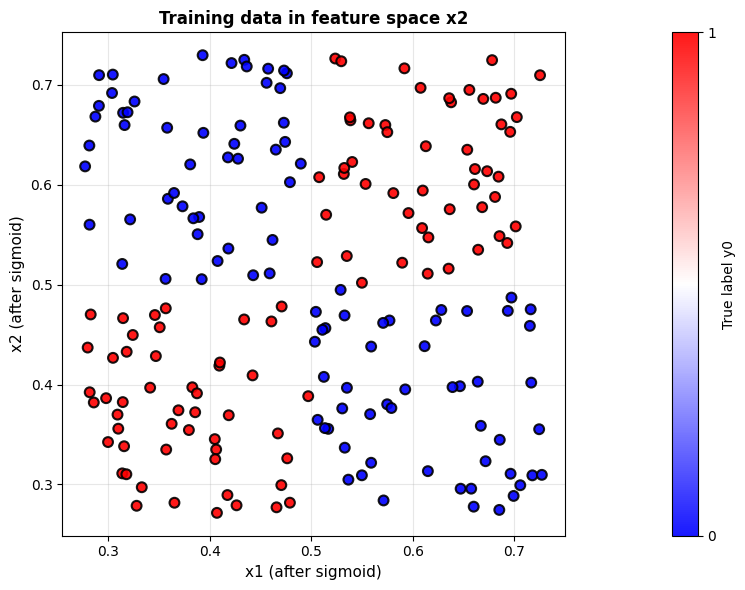

In [25]:
import matplotlib.pyplot as plt

def plot_data_and_probability(x, y, params=None, predict_proba_func=None, figsize=(8, 6)):
    """
    Plot training data and optionally forecasted probability.
    
    Parameters:
    -----------
    x : array-like, shape (n_samples, 2)
        Training data features
    y : array-like, shape (n_samples,)
        Training data labels (0 or 1)
    params : dict, optional
        Model parameters. If None, only data is plotted.
    predict_proba_func : callable, optional
        Function to predict probabilities: predict_proba_func(params, x)
        Required if params is not None.
    figsize : tuple, optional
        Figure size (default: (8, 6))
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Create a grid for probability contours (if model is provided)
    if params is not None and predict_proba_func is not None:
        x1_min, x1_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
        x2_min, x2_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
        xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                               np.linspace(x2_min, x2_max, 100))
        grid_points = np.c_[xx1.ravel(), xx2.ravel()]

        # Predict probabilities on the grid
        proba_grid = predict_proba_func(params, grid_points)
        proba_grid = np.array(proba_grid).reshape(xx1.shape)

        # Plot probability contours (reversed colormap: red = high prob for class 1)
        contour = ax.contourf(xx1, xx2, proba_grid, levels=20, cmap='RdYlBu_r', alpha=0.6)
        cbar1 = plt.colorbar(contour, ax=ax)
        cbar1.set_label('Forecasted probability p(y=1|x)', fontsize=10)

        # Add decision boundary (p=0.5)
        contour_lines = ax.contour(xx1, xx2, proba_grid, levels=[0.5], colors='black', 
                                   linewidths=2, linestyles='--', zorder=5)
        ax.clabel(contour_lines, inline=True, fontsize=10, fmt='p=0.5')
        
        title = 'Training Data and Forecasted Probability'
    else:
        title = 'Training data in feature space x2'

    # Plot training data points
    scatter = ax.scatter(x[:, 0], x[:, 1], c=y, cmap='bwr', 
                         edgecolor='k', linewidth=1.5, s=50, alpha=0.9, zorder=10)
    cbar2 = plt.colorbar(scatter, ax=ax, ticks=[0, 1], pad=0.15)
    cbar2.set_label('True label y0', fontsize=10)

    ax.set_xlabel('x1 (after sigmoid)', fontsize=11)
    ax.set_ylabel('x2 (after sigmoid)', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot the training data
plot_data_and_probability(x2, y0)

___

### 2.1.1 Logistische Regression mit JAX

Implementieren Sie das logistische Regressionsmodell und die negative Log-Likelihood-Verlustfunktion mit JAX. Stellen Sie sich JAX als Ersatz für NumPy mit automatischer Differentiation vor. Sie können den folgenden Code als Ausgangspunkt verwenden.

#### Parameter Initialisierung: `init_params`

In dieser Funktion werden die Modellparemter $w$ und $b$ initialisiert. Die Gewichte $w$ werden aus einer Normalverteilung gezogen, während der Bias $b$ auf Null gesetzt wird.

In [26]:
# ------------------------------------------------------------
# Parameter initialization (fully implemented)
# ------------------------------------------------------------
def init_params(seed=0):
    """
    Initialize parameters for logistic regression.

    Returns a dictionary:
        params = {
            "w": w,   # shape (2,)
            "b": b    # scalar
        }
    """
    key = jax.random.PRNGKey(seed)
    # Random initialization for weights (small values)
    w = 0.1 * jax.random.normal(key, (2,))
    # Bias initialized to zero
    b = jnp.array(0.0)
    return {"w": w, "b": b}

> **Wichtig**: Durch verwendung eines festen Seeds erzeugt die Funktion bei jedem Aufruf die gleichen initialen Parameter.

In [27]:
# Test the parameter initialization
params = init_params()
print("Initialized parameters:")
print("w:", params["w"])
print("b:", params["b"])
print(f"w shape: {params['w'].shape}, dtype: {params['w'].dtype}")

Initialized parameters:
w: [0.16226421 0.20252648]
b: 0.0
w shape: (2,), dtype: float32


#### Logistische Regression: `predict_proba`

Diese Funktion soll die Klassifikationswahrscheinlichkeit für die Klasse 1, also $P(y=1|x)$ für das logistische Regressionsmodell vorhersagen.

- Eingabe:
    - `params`: Ein Tupel `(W, b)`, wobei `W` die Gewichtsmatrix und `b` der Bias-Vektor ist.
    - `x`: Ein Eingabedatenarray der Form `(n_samples, n_features)`.
- Ausgabe:
    - JAX-Array mit Wahrscheinlichkeiten im Bereich [0, 1] der Form `(n_samples,)` bei einem Batch, bzw. `(1,)` bei einem einzelnen Beispiel.

Als Formel für die logistische Regression gilt:
$$P(y=1|x) = \sigma(w^T x + b)$$
mit 
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$
als Sigmoid-Funktion.

Die Klasse gibt also die Wahrscheinlichkeit zurück, mit welcher ein Punkt zur Klasse 1 gehört wobei $z = w^T x + b$ einen linearen Score darstellt, der die Entscheidung des Modells repräsentiert welches durch die Sigmoid-Funktion in eine Wahrscheinlichkeit umgewandelt wird.

##### Beispielrechnung
Wir nehmen an, dass die Parameter wie folgt initialisiert wurden:
$$w = \begin{bmatrix} 0.5 & 2 \end{bmatrix}, b = 0$$
Für einen Eingabepunkt
$$x = \begin{bmatrix} 1 & 1 \end{bmatrix}$$
berechnen wir zuerst den linearen Score:
$$z = w^T x + b = \begin{bmatrix} 0.5 \\ 2 \end{bmatrix} \begin{bmatrix} 1 & 1 \end{bmatrix} + 0 = 0.5 + 2 = 2.5$$
Anschließend wenden wir die Sigmoid-Funktion an, um die Wahrscheinlichkeit zu erhalten:
$$P(y=1|x) = \sigma(2.5) = \frac{1}{1 + e^{-2.5}} \approx 0.92$$
Bei diesem Eingabepunkt und dieser Parametrisierung gibt das Modell also eine Wahrscheinlichkeit von etwa 92% aus, dass der Punkt zur Klasse 1 gehört.

In [28]:
# ------------------------------------------------------------
# Model: p(y = 1 | x) given the parameters
# ------------------------------------------------------------
def predict_proba(params, x):
    """
    Compute p(y = 1 | x).
    
    #### Parameters:
    - params: dict with model parameters "w" and "b"
    - x: input features, shape (n_samples, 2)
    #### Returns:
    - p: predicted probabilities for class 1, shape (n_samples,)
    """
    w = params["w"]
    b = params["b"]
    
    # calculate linear score (logit)
    z = jnp.dot(x, w) + b

    # return sigmoid(z) = p
    return jax.nn.sigmoid(z)

In [29]:
# Test predict_proba
params = init_params()
x_test = jnp.array([[0.0, 0.0], [0.5, 0.5], [1.0, 1.0]])
proba_test = predict_proba(params, x_test)
print(f"Test predict_proba input: {x_test.tolist()}")
print("Test predict_proba output:", proba_test.tolist())

Test predict_proba input: [[0.0, 0.0], [0.5, 0.5], [1.0, 1.0]]
Test predict_proba output: [0.5, 0.5454728603363037, 0.5901996493339539]


##### Test mit Beipielwerten
Der folgende Test sollte die oben gezeigte Beispielrechnung bestätigen und eine Ausgabe von etwa 0.92 liefern.

In [30]:
params = {"w": jnp.array([0.5, 2.0]), "b": jnp.array(0.0)}
x_test = jnp.array([[1.0, 1.0]])
proba_test = predict_proba(params, x_test)
print(f"Test predict_proba input: {x_test.tolist()}")
print("Test predict_proba output:", proba_test.tolist())

Test predict_proba input: [[1.0, 1.0]]
Test predict_proba output: [0.9241418242454529]


#### Kostenfunktion: `nll_loss`

Diese Funktion berechnet die negative Log-Likelihood (NLL) für das logistische Regressionsmodell. Sie ist also die Kostenfunktion welche minimiert werden soll um $w$ und $b$ zu lernen.

- Eingabe:
    - `params`: Ein Tupel `(W, b)`, wobei `W` die Gewichtsmatrix und `b` der Bias-Vektor ist.
    - `x`: Ein Eingabedatenarray der Form `(n_samples, n_features)`.
    - `y`: Ein Array mit binären Zielwerten der Form `(n_samples,)`.
- Ausgabe:
    - Skalarwert des negativen Log-Likelihood-Verlusts.

Formel für die negative Log-Likelihood-Verlustfunktion:
$$\text{L} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p_i)) + (1 - y_i) \log(1 - p_i) \right]$$
mit
$$p_i = P(y=1|x_i) = \sigma(w^T x_i + b)$$

In [31]:
# ------------------------------------------------------------
# Negative Log-Likelihood loss
# ------------------------------------------------------------
def nll_loss(params, x, y, p_test=None, z_test = None):
    """
    Binary cross-entropy / negative log-likelihood.

    #### Parameters:
    - params: dict with model parameters "w" and "b"
    - x: input features, shape (n_samples, 2)
    - y: true labels, shape (n_samples,)
    #### Returns:
    - loss: scalar, negative log-likelihood loss
    """
    p = predict_proba(params, x) if p_test is None else p_test
    eps = 1e-15  # small constant to avoid log(0)
    w = params["w"]
    b = params["b"]
    z = jnp.dot(x, w) + b if z_test is None else z_test
    #return -jnp.mean(y * jnp.log(p + eps) + (1 - y) * jnp.log(1 - p + eps))
    return jnp.mean(jnp.logaddexp(0, z) - y * z)

> **Wichtig**: Für numerische Stabilität muss sichergestellt werden, dass die Argumente der Logarithmusfunktion nicht exakt 0 oder 1 sind da $\log(0)$ undefiniert ist. Daher wird in der Funktion ein kleiner Wert `eps` verwendet, um die Argumente zu begrenzen.

In [32]:
# Test nll_loss
params = init_params()
loss_test = nll_loss(params, x2, y0)
print("Test nll_loss:", loss_test)

Test nll_loss: 0.69820166


In [33]:
params = {"w": jnp.array([0.5, 0.5]), "b": jnp.array(0.0)}
print("Initialized parameters:")
print("w:", params["w"])
print("b:", params["b"])

aL = 0.0179862106
zL = -4.0

x = jnp.array([[1.0, 1.0]])
y = jnp.array([1.0])
loss_test = nll_loss(params, x, y, aL, zL)
print("Test nll_loss with custom params:", loss_test)

grad_f = jax.grad(nll_loss, argnums=0)
grads = grad_f(params, x, y)
print("Gradient w.r.t. w:", grads["w"])
print("Gradient w.r.t. b:", grads["b"])
grads

Initialized parameters:
w: [0.5 0.5]
b: 0.0
Test nll_loss with custom params: 4.01815
Gradient w.r.t. w: [-0.26894146 -0.26894146]
Gradient w.r.t. b: -0.26894146


{'b': Array(-0.26894146, dtype=float32, weak_type=True),
 'w': Array([-0.26894146, -0.26894146], dtype=float32)}

#### Trainingsfunktion: `train`

Die Trainingsfunktion implementiert den Full-Batch-Gradientenabstieg zur Optimierung der Modellparameter $w$ und $b$.

Die Funktion erstellt also ein Netzwerk mit einem einzigen Neuron Outputneuron (logistische Regression) und optimiert die Parameter mittels Gradientenabstieg basierend auf der negativen Log-Likelihood-Verlustfunktion.

- Eingabe:
    - `x`: Ein Eingabedatenarray der Form `(n_samples, n_features)`.
    - `y`: Ein Array mit binären Zielwerten der Form `(n_samples,)`.
    - `n_steps`: Anzahl der Trainingsschritte (Standard: 1000).
    - `learning_rate`: Lernrate für den Gradientenabstieg (Standard: 0.1).
- Ausgabe:
    - Ein Tupel `(W, b)` mit den trainierten Modellparametern. 

In [34]:
# ------------------------------------------------------------
# Full-batch gradient descent training loop
# ------------------------------------------------------------
def train(x, y, lr=0.5, n_steps=2000, init_seed=0):
    """
    Full-batch gradient descent training.

    TODO:
      - Initialize params = init_params()
      - Define grad_loss = jax.grad(nll_loss)
      - Loop over steps:
          * compute gradients
          * update w and b
      - Print loss every 200 steps (optional)
      - Return final params
    """
    # Initialize parameters
    params = init_params(init_seed)

    # Define gradient function using JAX
    grad_loss = jax.grad(nll_loss)

    for step in range(n_steps):
        # Compute gradients
        grads = grad_loss(params, x, y)

        # Update parameters
        params["w"] -= lr * grads["w"]
        params["b"] -= lr * grads["b"]
        
        # Optional: Print loss every 200 steps
        if step % 200 == 0:
            current_loss = nll_loss(params, x, y)
            print(f"Step {step}, Loss: {current_loss:.4f}")
    return params

Step 0, Loss: 0.6967
Step 200, Loss: 0.6930
Step 400, Loss: 0.6927
Step 600, Loss: 0.6925
Step 800, Loss: 0.6924
Step 1000, Loss: 0.6923
Step 1200, Loss: 0.6923
Step 1400, Loss: 0.6923
Step 1600, Loss: 0.6923
Step 1800, Loss: 0.6923


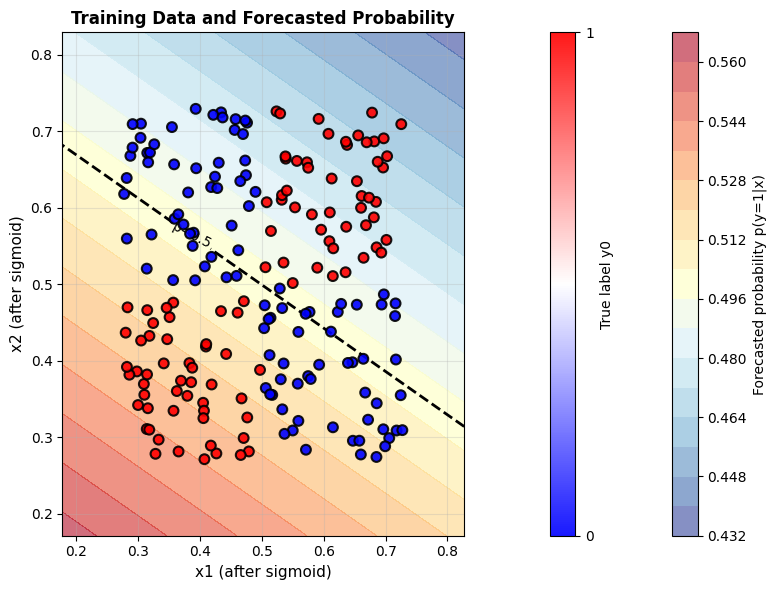

In [35]:
# ------------------------------------------------------------
# After students implement everything:
params = train(x2, y0)
# ------------------------------------------------------------
# Plot the data and forecasted probability
plot_data_and_probability(x2, y0, params, predict_proba)

In [36]:
x_test = jnp.array([[0.0, 0.0], [0.5, 0.5], [1.0, 1.0]])
proba_test = predict_proba(params, x_test)
print(f"Test predict_proba input: {x_test.tolist()}")
print("Test predict_proba output:", proba_test.tolist())

Test predict_proba input: [[0.0, 0.0], [0.5, 0.5], [1.0, 1.0]]
Test predict_proba output: [0.5971516370773315, 0.499927818775177, 0.4027094841003418]


#### Bewertung des Trainings

Das Training zeigt, dass der Verlust sich nur wenig verändert was zum einen an den Daten sowie an der Einfachheit des Modells liegt.

Das Modell ist geometrisch Betrachtet nichts anderes als eine lineare Entscheidungsgrenze die die zwei Klassen trennt, also wie folgt aufgebaut ist:
$$z = w^T x + b = 0$$
was nichts anderes als eine Gerade in 2D ist.

> **Hinweis**: Da die Daten nicht linear trennbar sind, kann das Modell nicht perfekt trainiert werden. Das erstellte "Netzwerk" ist eigentlich nur ein einzelnes Neuron mit einer Sigmoid-Aktivierungsfunktion also ein einziges Perzeptron. Ein einzelnes Perzeptron (auch binärer Klassifikator genannt) kann nur linear trennbare Daten korrekt klassifizieren.

___

### 2.1.2 Multilayer Perceptron

Fügen Sie dem Modell eine versteckte Ebene der Dimension 16 hinzu und wiederholen Sie [2.1.1](#211-logistische-regression-mit-jax). 

Um die Leistung zu verbessern, verwenden Sie jit, indem Sie den Aktualisierungsschritt in eine jit-Funktion einfügen.

```python
@jax.jit
def update(params, x, y, lr):
    grads = jax.grad(nll_loss)(params, x, y)
    return {
        "W1": params["W1"] - lr * grads["W1"],
        # YOUR CODE HERE
        }
```

In [37]:
@jax.jit
def update(params, x, y, lr):
    grads = jax.grad(nll_loss)(params, x, y)
    return {
        "W1": params["W1"] - lr * grads["W1"],
        
    }

In diesem Abschnitt implementieren wir ein kleines MLP (2 → 16 → 1) mit ReLU-Aktivierung, eine numerisch stabile NLL (BCE-with-logits) und einen jit-kompilierten Update-Schritt.

#### Anpassung der Parameter Initialisierung: `init_params_mlp`
Um die Parameter für die geforderte MLP-Architektur zu initialisieren, muss die Funktion `init_params` angepasst werden. Die Funktion sollte die Gewichte und Biases für zwei Schichten initialisieren: eine Eingabeschicht mit 2 Neuronen, eine versteckte Schicht mit 16 Neuronen und eine Ausgabeschicht mit 1 Neuron.

In [38]:
import jax
import jax.numpy as jnp

# ------------------------------
# MLP Parameter-Initialisierung
# ------------------------------
def init_mlp_params(hidden_dim: int = 16, seed: int = 0):
    """
    Initialize parameters for a simple MLP with one hidden layer.
    
    Parameters
    ----------
    hidden_dim : int
        Number of neurons in the hidden layer.
    seed : int
        Random seed for initialization.

    Returns
    -------
    params : dict
        Dictionary containing initialized weights and biases:
        {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    """
    key = jax.random.PRNGKey(seed)
    # generate different keys for each parameter
    k1, k2 = jax.random.split(key, 2)
    
    # Initialize weights and biases from input to hidden layer
    W1 = 0.1 * jax.random.normal(k1, (2, hidden_dim))
    b1 = jnp.zeros((hidden_dim,))

    # Initialize weights and biases from hidden to output layer
    W2 = 0.1 * jax.random.normal(k2, (hidden_dim, 1))
    b2 = jnp.array(0.0)
    
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

In [39]:
# Test the MLP parameter initialization
import pandas as pd
mlp_params = init_mlp_params()
pd_mlp_params = pd.DataFrame({k: [v.shape, v.dtype] for k, v in mlp_params.items()}, index=["shape", "dtype"])
print("Initialized MLP parameters:")
print(pd_mlp_params)

Initialized MLP parameters:
            W1       b1       W2       b2
shape  (2, 16)    (16,)  (16, 1)       ()
dtype  float32  float32  float32  float32


#### Anpassung der Vorhersagefunktion: `predict_proba`
Da das Modell jetzt eine versteckte Schicht enthält, muss die Vorhersagefunktion ebenfalls angepasst werden. 
Die Funktion soll die Eingabedaten durch die erste Schicht (Eingabe zu versteckt) mit einer Aktivierungsfunktion (hier ReLu) und dann durch die zweite Schicht (versteckt zu Ausgabe) leiten, um die endgültigen Logits zu erhalten.

Für das Netzwerk ergibt sich also folgende verschachtelte Funktion:
$$P(y=1|x) = \sigma(W_2 \cdot \text{ReLU}(W_1 x + b_1) + b_2)$$

In [40]:
# ------------------------------
# MLP Forward (Logits & Proba)
# ------------------------------
def mlp_logits(params, x):
    x = jnp.asarray(x)
    if x.ndim == 1:
        x = x[None, :]
    h = jax.nn.relu(jnp.dot(x, params["W1"]) + params["b1"])  # (N, 16)
    z = jnp.dot(h, params["W2"]) + params["b2"]               # (N, 1)
    return z.squeeze(-1)                                        # (N,) oder ()

def mlp_predict_proba(params, x):
    return jax.nn.sigmoid(mlp_logits(params, x))

In [41]:
# -------------------------------------
# Numerisch stabile NLL (BCE-with-logits)
# -------------------------------------
def nll_loss_mlp(params, x, y):
    y = jnp.asarray(y)
    z = mlp_logits(params, x)
    return jnp.mean(jnp.logaddexp(0.0, z) - y * z)

# ------------------------------
# jit-kompiliertes Update
# ------------------------------
@jax.jit
def update(params, x, y, lr):
    grads = jax.grad(nll_loss_mlp)(params, x, y)
    return {
        "W1": params["W1"] - lr * grads["W1"],
        "b1": params["b1"] - lr * grads["b1"],
        "W2": params["W2"] - lr * grads["W2"],
        "b2": params["b2"] - lr * grads["b2"],
    }

Step 0, MLP Loss: 0.6933
Step 200, MLP Loss: 0.6929
Step 400, MLP Loss: 0.6928
Step 600, MLP Loss: 0.6927
Step 800, MLP Loss: 0.6925
Step 1000, MLP Loss: 0.6924
Step 1200, MLP Loss: 0.6922
Step 1400, MLP Loss: 0.6920
Step 1600, MLP Loss: 0.6918
Step 1800, MLP Loss: 0.6915
Step 2000, MLP Loss: 0.6912
Step 2200, MLP Loss: 0.6908
Step 2400, MLP Loss: 0.6904
Step 2600, MLP Loss: 0.6899
Step 2800, MLP Loss: 0.6893
Step 3000, MLP Loss: 0.6886
Step 3200, MLP Loss: 0.6878
Step 3400, MLP Loss: 0.6868
Step 3600, MLP Loss: 0.6857
Step 3800, MLP Loss: 0.6843


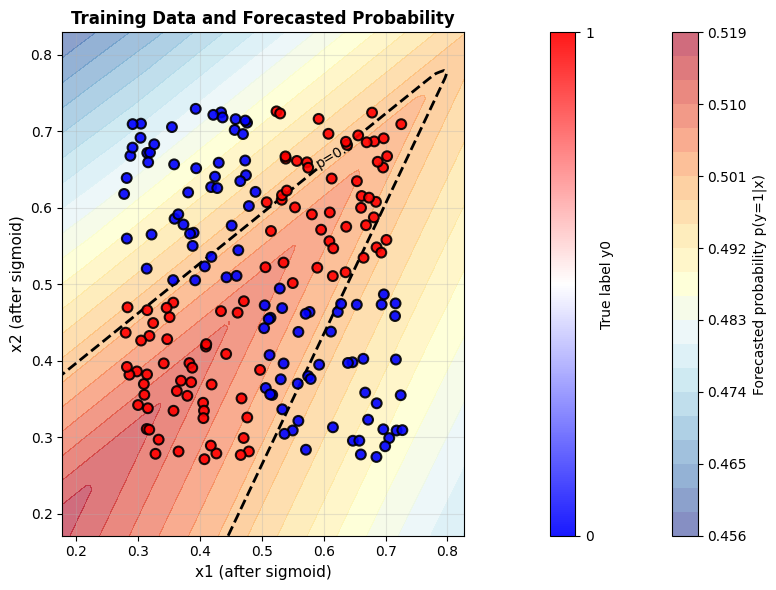

In [42]:
# Kleiner Trainingslauf für das MLP

seed = 1

def train_mlp(x, y, lr=0.5, n_steps=2000, seed=seed):
    params = init_mlp_params(hidden_dim=16, seed=seed)
    for step in range(n_steps):
        params = update(params, x, y, lr)
        if step % 200 == 0:
            current_loss = nll_loss_mlp(params, x, y)
            print(f"Step {step}, MLP Loss: {current_loss:.4f}")
    return params

# Trainieren und Visualisieren
params_mlp = train_mlp(x2, y0, lr=0.03, n_steps=4000, seed=seed)
plot_data_and_probability(x2, y0, params_mlp, mlp_predict_proba)

___

### 2.1.3 Implementieren Sie das MLP in Keras.

Implementieren Sie das MLP in Keras unter Verwendung der sequenziellen API.

Wir implementieren ein kleines MLP mit der Keras-Sequential-API (2 → 16 → 1), kompilieren mit Adam und Binary Cross-Entropy und trainieren es auf den vorhandenen Daten `x2, y0`.

In [43]:
import keras
from keras import layers, Sequential, optimizers, losses

# Optional: Reproduzierbarkeit
try:
    keras.utils.set_random_seed(0)
except Exception:
    pass

# Modell definieren
model = Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

# Kompilieren
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.03),
    loss=losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# Trainieren
history = model.fit(
    x2, y0,
    epochs=100,
    batch_size=32,
    verbose=0,
    validation_split=0.2
)
print(f"Final train acc: {history.history['accuracy'][-1]:.4f}")
print(f"Final val acc:   {history.history['val_accuracy'][-1]:.4f}")

Final train acc: 0.9500
Final val acc:   0.4500


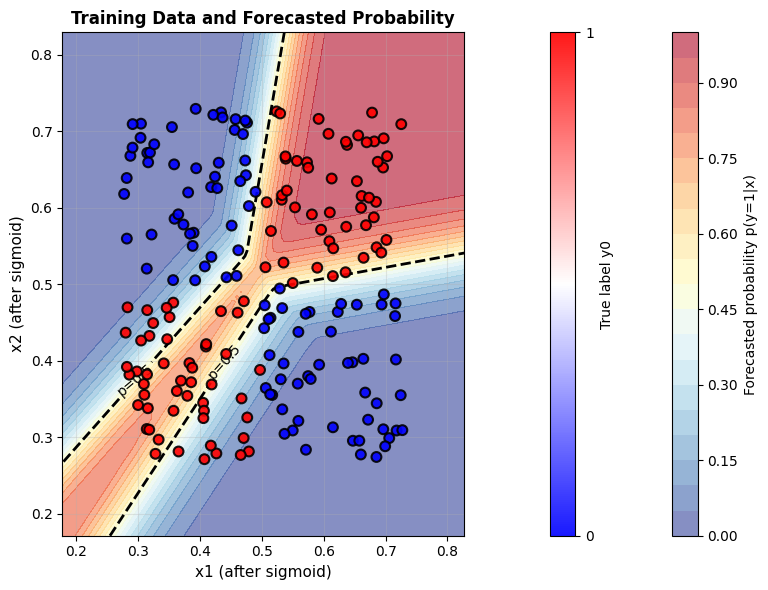

In [44]:
import numpy as np

# Keras-Proba-Wrapper für die bestehende Plot-Funktion

def predict_proba_keras(model, x):
    preds = model.predict(np.asarray(x), verbose=0)
    return preds.ravel()

# Visualisierung mit der vorhandenen Utility
plot_data_and_probability(x2, y0, model, predict_proba_keras)